### SAのテンプレート

In [1]:
ex_num = "007"

In [2]:
import os
# 環境によって変更
os.chdir('/home/jovyan/work/notebook')

In [3]:
class CFG:
    path = "../model"
    # path = "../../output"
    base_file_path = "../input/sub20241221.csv"
    
    # 焼きなましのパラメータ
    temperature=10
    cooling_rate=0.999
    iteration=100
    batch_size=8
    neighbor_types = ["swap", "insert", "inverse", "slide"]

In [4]:
import numpy as np
import pandas as pd
import os
import time
import csv

from tqdm.notebook import tqdm

import random
from typing import List, Callable
import itertools, math
from typing import List, Tuple

from utils import PerplexityCalculator
# 可視化用
import matplotlib.pyplot as plt

### データ読み込み

In [5]:
df = pd.read_csv(CFG.base_file_path)

In [6]:
sub_df = df.copy()
sub_df["best_value"] = 0

In [7]:
df

,id,text
0,0,reindeer mistletoe elf gingerbread family adve...
1,1,reindeer sleep walk the night and drive mistle...
2,2,jingle yuletide carol cheer holly stocking chi...
3,3,sleigh the holly jingle unwrap gifts of magi r...
4,4,peppermint candy milk chocolate eggnog fruitca...
5,5,poinsettia yuletide eggnog fruitcake gingerbre...


### 関数

In [8]:
def plot_score_and_temperature(scores_history, temp_history):
    # x 軸: イテレーション
    x = range(len(scores_history))
    
    # Figure と Axes を作成
    fig, ax1 = plt.subplots(figsize=(8,5))
    
    # スコア用の軸 (左)
    color_score = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Score (Perplexity)', color=color_score)
    ax1.plot(x, scores_history, label='Score', color=color_score)
    ax1.tick_params(axis='y', labelcolor=color_score)
    
    # 温度用の軸 (右) : twinx で第二のY軸を作成
    ax2 = ax1.twinx()
    color_temp = 'tab:red'
    ax2.set_ylabel('Temperature', color=color_temp)
    ax2.plot(x, temp_history, label='Temperature', color=color_temp)
    ax2.tick_params(axis='y', labelcolor=color_temp)
    
    # タイトル等
    plt.title('Score & Temperature Transition')
    fig.tight_layout()
    plt.show()

In [9]:
# 2単語組み合わせ全てから最低スコアとなるペアを探す
def find_initial_pair(
    CFG,
    scorer,
    words
):
    best_score = float('inf')
    best_pair = None
    for i in range(len(words)):
        perms = []
        for j in range(i+1, len(words)):
            pair = [words[i], words[j]]
            perms.append(" ".join(pair))
        
        scores = scorer.get_perplexity(perms, batch_size=CFG.batch_size)
        for j, perm in enumerate(perms):
            if scores[j] < best_score:
                best_score = scores[j]
                best_pair = perm.split(" ")
                
                # print(f"best_score: {best_score}, best_pair: {best_pair}")
     
    return best_pair, best_score

In [10]:
# 文字列のファイルからコストを最小化する文字列を生成する
def greedy_add_initialize(
    CFG,
    scorer,
    initial_words: list
):
    
    # 全単語
    candidates = initial_words[:]

    print("candidates:", candidates)
    print("-----初期配置の組み合わせ計算開始-----")
    # 初期配置を求める
    initial, initial_score = find_initial_pair(
        CFG,
        scorer,
        candidates
    )
    print("-----初期配置の組み合わせ計算終了-----")
    for w in initial:
        candidates.remove(w)

    print("initial:", initial, initial_score)
    current_order = initial[:]

    print("-----貪欲法での挿入開始-----")
    # 貪欲に残りを挿入
    while candidates:
        best_score = float('inf')
        best_word = None
        best_pos = None

        # 残っている単語それぞれについて
        for w in candidates:
            # current_orderのあらゆる挿入位置を試す
            # 挿入位置は0からlen(current_order)まで
            
            perms = []
            for pos in range(len(current_order) + 1):
                new_order = current_order[:pos] + [w] + current_order[pos:]
                perms.append(" ".join(new_order))
                
            scores = scorer.get_perplexity(perms, batch_size=CFG.BATCH_SIZE)
                
            for pos in range(len(current_order) + 1):
                if scores[pos] < best_score:
                    best_score = scores[pos]
                    best_word = w
                    best_pos = pos
                    
                    # print("best_word:", best_word, best_score)
        
        # best_wordをbest_posに挿入
        current_order.insert(best_pos, best_word)
        candidates.remove(best_word)
        print("current_order:", current_order, best_score)
    print("-----貪欲法での挿入終了-----")
    
    best_score = scorer.get_perplexity([" ".join(current_order)], batch_size=1)[0]
    
    return current_order, best_score

In [11]:
def generate_neighbor(sequence, neighbor_type='swap'):
    """
    sequence: list of words
    neighbor_type: str, 近傍生成の種類 ('swap', 'insert', etc.)
    """
    new_seq = sequence[:]
    length = len(new_seq)

    if neighbor_type == 'swap':
        # ランダムに2つの位置を選んで入れ替える
        a, b = random.sample(range(length), 2)
        new_seq[a], new_seq[b] = new_seq[b], new_seq[a]

    elif neighbor_type == 'insert':
        # ある単語を抜き出し、別の位置に挿入する
        idx = random.randint(0, length - 1)
        word = new_seq.pop(idx)
        new_pos = random.randint(0, length - 1)
        new_seq.insert(new_pos, word)

    elif neighbor_type == 'shuffle_segment':
        # ランダムな部分区間を決めてシャッフル
        start = random.randint(0, length - 2)
        end = random.randint(start + 1, length - 1)
        segment = new_seq[start:end+1]
        random.shuffle(segment)
        new_seq[start:end+1] = segment

    elif neighbor_type == 'reverse_segment':
        # ランダムな部分区間を決めて反転
        start = random.randint(0, length - 2)
        end = random.randint(start + 1, length - 1)
        segment = new_seq[start:end+1]
        new_seq[start:end+1] = list(reversed(segment))

    # 他にも様々な近傍操作を追加可能

    return new_seq

In [12]:
def search_annealing(
    scorer,
    initial_sequence,
    temperature: float = 1.0,
    cooling_rate: float = 0.999,
    iteration: int = 1000,
    batch_size: int = 10,
    neighbor_types: list = None
):
    """
    焼きなまし法による探索

    Parameters
    ----------
    CFG: 設定用（必要に応じて）
    scorer: perplexityを計算できるオブジェクト
    initial_sequence: 初期の単語リスト
    temperature: 開始時の温度
    cooling_rate: 温度の減少率
    iteration: 探索の反復回数
    batch_size: 1ステップで生成する近傍候補の数
    neighbor_types: 近傍生成の種類を指定するリスト
    """
    if neighbor_types is None:
        neighbor_types = ['swap', 'insert', 'shuffle_segment', 'reverse_segment']

    # 初期状態
    current_seq = initial_sequence[:]
    best_seq = current_seq[:]
    best_score = scorer.get_perplexity([" ".join(current_seq)], batch_size=1)[0]

    # current_scoreの計算
    current_score = best_score

    # スコア推移を記録するリスト
    scores_history = []
    temp_history = []
    
    for itr in tqdm(range(iteration)):
        # 記録（ループの冒頭 or 最後のどちらでもOK）
        scores_history.append(current_score)
        temp_history.append(temperature)
        
        # 近傍候補をまとめて生成
        neighbor_candidates = []
        for _ in range(CFG.batch_size):
            # 近傍操作の種類をランダムに選ぶ
            n_type = random.choice(neighbor_types)
            neighbor_seq = generate_neighbor(current_seq, n_type)
            neighbor_candidates.append(neighbor_seq)

        
        
        # まとめてスコアを計算（GPUを活用）
        texts = [" ".join(seq) for seq in neighbor_candidates]
        # print("texts:", texts)
        
        scores = scorer.get_perplexity(texts, batch_size=batch_size)
        # print("scores:", scores)
        
        # 候補の中から1つを焼きなまし法の確率的受容ルールで選ぶ
        chosen_idx = None
        for i, (cand_seq, cand_score) in enumerate(zip(neighbor_candidates, scores)):
            # スコアが良ければ必ず受容
            if cand_score < current_score:
                chosen_idx = i
                break
            else:
                # メトロポリス法に基づく確率的受容
                delta = cand_score - current_score
                accept_prob = math.exp(-delta / temperature) if delta > 0 else 1.0
                if random.random() < accept_prob:
                    chosen_idx = i
                    break

        # 受容する近傍が1つもなかった場合はスキップ可
        if chosen_idx is not None:
            current_seq = neighbor_candidates[chosen_idx]
            current_score = scores[chosen_idx]

            # ベストの更新
            if current_score < best_score:
                best_seq = current_seq[:]
                best_score = current_score
                print(f"iter {itr}: best_score: {best_score}")
                print("best_seq:", best_seq)

        # 温度を下げる
        temperature *= cooling_rate
        
    return best_seq, best_score, scores_history, temp_history

In [13]:
def search_optimal_permutation(
    CFG,
    id: int, 
    scorer
):
    
    df = pd.read_csv(CFG.base_file_path)
    
    start = time.time()
    # 文字列を単語に分割
    words = df.loc[id,"text"].split()
    
    initial_sequence = words[:]
    print("--------初期配置の組み合わせ計算開始---------")
    # initial_sequence, initial_score = greedy_add_initialize(
    #     CFG,
    #     scorer=scorer,
    #     initial_words=words
    # )
    
    # print(f"{id}th sample: {initial_sequence}")
    # print(f"Elapsed time: {time.time() - start:.2f} sec")
    # print(f"initial_score: {initial_score}")
    print("--------初期配置の組み合わせ計算終了---------")
    
    print("---------焼きなまし処理開始---------")
    best_sequence, best_score, scores_history, temp_history = search_annealing(
        scorer=scorer,
        initial_sequence=initial_sequence,
        temperature=CFG.temperature,
        cooling_rate=CFG.cooling_rate,
        iteration=CFG.iteration,
        batch_size=CFG.batch_size,
        neighbor_types=CFG.neighbor_types
    )
    print("---------焼きなまし処理終了---------")
    
    print(f"{id}th sample: {best_sequence}")
    print(f"Elapsed time: {time.time() - start:.2f} sec")
    print(f"best_score: {best_score}")
    
    plot_score_and_temperature(scores_history, temp_history)
    
    return best_sequence, best_score


In [14]:
# 文字列型にのみダブルクォーテーションを付ける関数
def add_quotes_to_strings(value):
    if isinstance(value, str):  # 文字列型の場合
        return f'"{value}"'
    return value  # それ以外はそのまま

In [15]:
# LOAD GEMMA SCORER
scorer = PerplexityCalculator(f'{CFG.path}/gemma_2_9b')

cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [16]:
# scorer.clear_gpu_memory()

Processing 5th sample
--------初期配置の組み合わせ計算開始---------
--------初期配置の組み合わせ計算終了---------
---------焼きなまし処理開始---------


  0%|          | 0/100 [00:00<?, ?it/s]

---------焼きなまし処理終了---------
5th sample: ['poinsettia', 'yuletide', 'eggnog', 'fruitcake', 'gingerbread', 'cookie', 'holiday', 'greeting', 'card', 'ornament', 'holly', 'hohoho', 'jingle', 'beard', 'jump', 'of', 'joy', 'kaggle', 'laugh', 'magi', 'milk', 'merry', 'mistletoe', 'night', 'naughty', 'and', 'nice', 'nutcracker', 'ornament', 'of', 'cheer', 'peace', 'peppermint', 'candy', 'polar', 'bow', 'puzzle', 'reindeer', 'relax', 'scrooge', 'season', 'cheer', 'sleigh', 'sing', 'and', 'carol', 'sleep', 'in', 'eat', 'advent', 'candle', 'angel', 'bake', 'chocolate', 'chimney', 'fireplace', 'chimney', 'fireplace', 'decorations', 'snowglobe', 'stocking', 'game', 'give', 'as', 'it', 'is', 'not', 'from', 'the', 'grinch', 'star', 'that', 'night', 'toy', 'drive', 'elf', 'doll', 'unwrap', 'the', 'gifts', 'wrapping', 'paper', 'visit', 'with', 'the', 'family', 'we', 'wish', 'you', 'to', 'dream', 'believe', 'and', 'have', 'hope', 'wonder', 'walk', 'workshop', 'workshop', 'wreath']
Elapsed time: 160.45 s

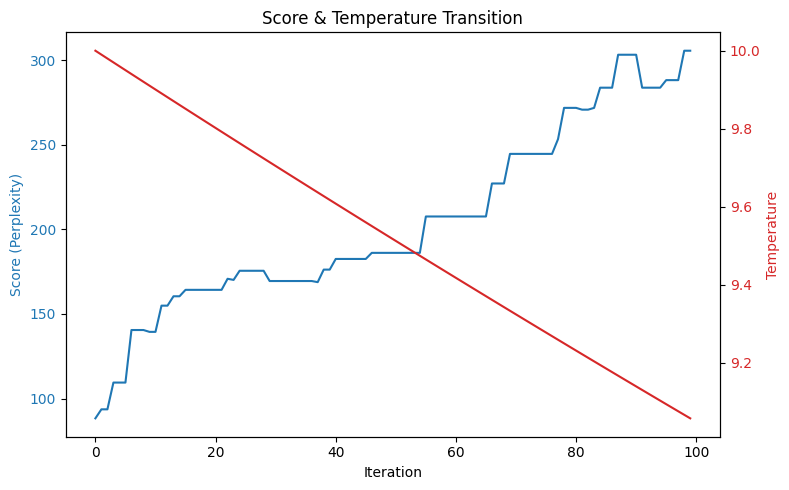

Best sequence: ['poinsettia', 'yuletide', 'eggnog', 'fruitcake', 'gingerbread', 'cookie', 'holiday', 'greeting', 'card', 'ornament', 'holly', 'hohoho', 'jingle', 'beard', 'jump', 'of', 'joy', 'kaggle', 'laugh', 'magi', 'milk', 'merry', 'mistletoe', 'night', 'naughty', 'and', 'nice', 'nutcracker', 'ornament', 'of', 'cheer', 'peace', 'peppermint', 'candy', 'polar', 'bow', 'puzzle', 'reindeer', 'relax', 'scrooge', 'season', 'cheer', 'sleigh', 'sing', 'and', 'carol', 'sleep', 'in', 'eat', 'advent', 'candle', 'angel', 'bake', 'chocolate', 'chimney', 'fireplace', 'chimney', 'fireplace', 'decorations', 'snowglobe', 'stocking', 'game', 'give', 'as', 'it', 'is', 'not', 'from', 'the', 'grinch', 'star', 'that', 'night', 'toy', 'drive', 'elf', 'doll', 'unwrap', 'the', 'gifts', 'wrapping', 'paper', 'visit', 'with', 'the', 'family', 'we', 'wish', 'you', 'to', 'dream', 'believe', 'and', 'have', 'hope', 'wonder', 'walk', 'workshop', 'workshop', 'wreath']
Best score: 88.27604237373367


/tmp/ipykernel_63/1733285752.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '88.27604237373367' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sub_df.loc[i, "best_value"] = best_score


In [17]:
for i in [5]:
    
    print(f"Processing {i}th sample")
    best_sequence, best_score = search_optimal_permutation(
        CFG,
        id=i,
        scorer=scorer,
    )
    
    print("Best sequence:", best_sequence)
    print("Best score:", best_score)
    sub_df.loc[i, "best_value"] = best_score
    sub_df.loc[i, "text"] = " ".join(best_sequence)



In [18]:
sub_df

,id,text,best_value
0,0,reindeer mistletoe elf gingerbread family adve...,0.000000
1,1,reindeer sleep walk the night and drive mistle...,0.000000
2,2,jingle yuletide carol cheer holly stocking chi...,0.000000
3,3,sleigh the holly jingle unwrap gifts of magi r...,0.000000
4,4,peppermint candy milk chocolate eggnog fruitca...,0.000000
5,5,poinsettia yuletide eggnog fruitcake gingerbre...,88.276042


In [19]:
# 各セルに関数を適用
sub_df["text"] = sub_df["text"].astype(str)
sub_df = sub_df.applymap(add_quotes_to_strings)

/tmp/ipykernel_63/428122046.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sub_df = sub_df.applymap(add_quotes_to_strings)


In [20]:
sub_df[["id", "text"]].to_csv(f"{path}/out/submission_{ex_num}.csv", index=False, header=True, quoting=csv.QUOTE_NONE)
sub_df.to_csv(f"{path}/out/score_{ex_num}.csv", index=False, header=True, quoting=csv.QUOTE_NONE)

NameError: name 'path' is not defined

In [18]:
np.mean(sub_df["best_value"])

np.float64(415.94398656888114)